# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path
from models import db, Routing, Job, Schedule, JobOperation

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 15 # 15 min

In [4]:
data_path = get_path("data", "lateness")
file_template = "02_{text}.csv"

In [5]:
db.close()
db.connect()
Schedule.drop_table()
db.create_tables([Schedule])

JobOperation.drop_table()
db.create_tables([JobOperation])

db.close()

True

## Laden des fertigen Datensatzes (60 Tage Ankunft)

In [6]:
# Jobs
df_jobs_times = Job.get_dataframe(version="base")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*60]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,base
1,J25-0001,6,129,1440,2338,open,base
2,J25-0002,0,198,1440,3744,open,base
3,J25-0003,2,243,1440,3379,open,base
4,J25-0004,3,287,1440,4856,open,base
...,...,...,...,...,...,...,...
1188,J25-1188,8,85975,86400,88866,open,base
1189,J25-1189,1,86001,86400,88375,open,base
1190,J25-1190,5,86033,86400,87868,open,base
1191,J25-1191,1,86084,86400,88251,open,base


In [7]:
Job.add_jobs_from_dataframe(df_jobs_times, version="lateness", status="open")

✅ 1193 Jobs (Version 'lateness') wurden hinzugefügt oder aktualisiert.


In [8]:
# Routings
df_routings = Routing.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [9]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

In [10]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
11925,J25-1192,3,5,M08,52
11926,J25-1192,3,6,M07,85
11927,J25-1192,3,7,M03,98
11928,J25-1192,3,8,M09,22


In [11]:
JobOperation.add_from_dataframe(df_jssp, version="lateness", status="open")

✅ 11930 JobOperation-Einträge (Version 'lateness', Status 'open') wurden hinzugefügt oder aktualisiert.


In [12]:
df_jobs_ops = JobOperation.get_dataframe(version="lateness")
df_jobs_ops

,Job,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,M00,0,None,None,76.0,lateness,open
1,J25-0000,M01,1,None,None,69.0,lateness,open
2,J25-0000,M03,2,None,None,76.0,lateness,open
3,J25-0000,M05,3,None,None,51.0,lateness,open
4,J25-0000,M02,4,None,None,85.0,lateness,open
...,...,...,...,...,...,...,...,...
11925,J25-1192,M08,5,None,None,52.0,lateness,open
11926,J25-1192,M07,6,None,None,85.0,lateness,open
11927,J25-1192,M03,7,None,None,98.0,lateness,open
11928,J25-1192,M09,8,None,None,22.0,lateness,open


### Params

In [13]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [14]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [15]:
# alle aktuelle "offenen" Jobs
df_job_times_curr = Job.get_dataframe(version="base", arrival_time_max=day_start, status="open")
df_job_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,base
1,J25-0001,6,129,1440,2338,open,base
2,J25-0002,0,198,1440,3744,open,base
3,J25-0003,2,243,1440,3379,open,base
4,J25-0004,3,287,1440,4856,open,base
5,J25-0005,1,498,1440,3106,open,base
6,J25-0006,9,790,1440,3539,open,base
7,J25-0007,5,925,1440,2929,open,base
8,J25-0008,4,988,1440,3541,open,base
9,J25-0009,7,1004,1440,3578,open,base


In [16]:
#  JSSP zu allen "offenen" Jobs
df_jssp_temp = get_jssp_for_jobs(df_job_times_curr, df_routings)
df_jssp_temp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [17]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JobOperation.get_dataframe(version="lateness", jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


### A) Scheduling

In [18]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.11 Sekunden


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [19]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              16
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


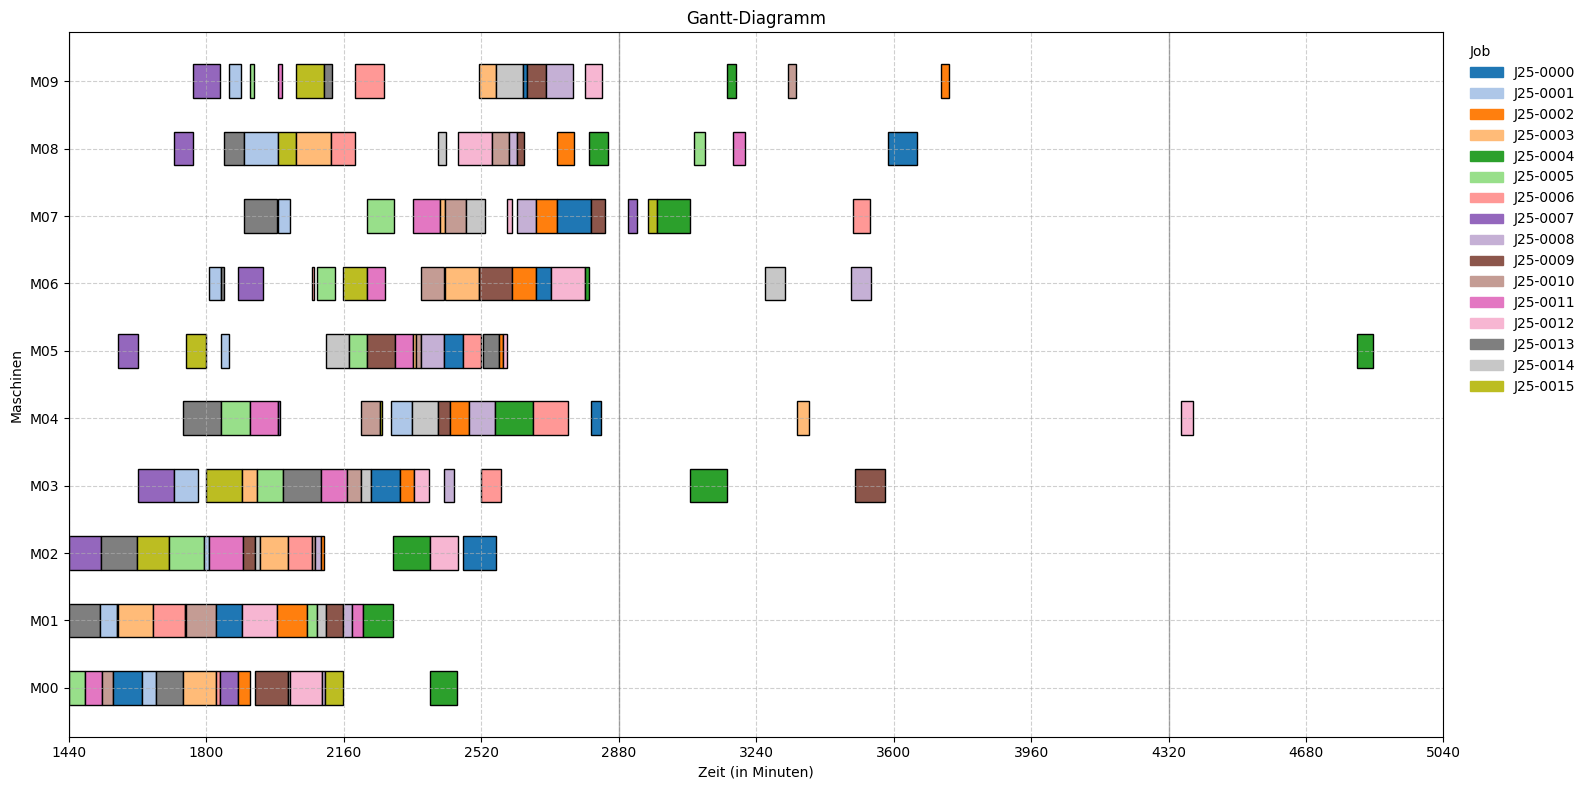

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [20]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [21]:
df_schedule

,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [22]:
json_schedule = df_schedule.to_dict(orient='records')  # ✅ Gibt list[dict]

Schedule.add_schedule(
    data=json_schedule,  # ✅ nicht als String!
    date=day_numb,
    description="init",
    version="lateness"
)

✅ Schedule hinzugefügt (Version=lateness, Date=1)


### C) Simulation

In [23]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:41:18] Job J25-0005 finished on M00 (after 41 minutes 19 seconds)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:19:20] Job J25-0013 finished on M01 (after 79 minutes 20 seconds)
[Day 1 01:20:09] Job J25-0011 finished on M00 (after 37 minutes 10 seconds)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:26:00] Job J25-0010 started on M00
[Day 1 01:33:15] Job J25-0007 finished on M02 (after 93 minutes 15 seconds)
[Day 1 01:33:15] Job J25-0013 started on M02
[Day 1 01:51:32] Job J25-0010 finished on M00 (after 25 minutes 32 seconds)
[Day 1 01:55:00] Job J25-0000 started on M00
[Day 1 02:05:17] Job J25-0001 finished on M01 (after 44 minutes 17 seconds)
[Day 1 02:07:00] Job J25-0007 started on M01
[Day 1 02:08:57] Job J25-0007 finished on M01 (after 01 minute 57 seconds)
[Day 1 02:09:00] Job J25-0003 started on M01
[Day 1 02:09:00] Jo

In [24]:
df_execution 

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1555.00,68.64,1623.64
1,J25-0000,8,1,M01,79,1840.93,54.01,1894.94
2,J25-0000,8,2,M03,79,2301.78,96.84,2398.62
3,J25-0000,8,3,M05,79,2471.61,47.14,2518.75
4,J25-0000,8,4,M02,79,2537.88,84.15,2622.03
...,...,...,...,...,...,...,...,...
136,J25-0015,5,4,M08,1436,2036.37,33.83,2070.20
137,J25-0015,5,5,M09,1436,2070.20,72.81,2143.01
138,J25-0015,5,6,M00,1436,2152.69,62.33,2215.02
139,J25-0015,5,7,M06,1436,2215.02,74.27,2289.29


In [25]:
df_ops_finished = df_execution[df_execution.End < day_end]
df_ops_finished

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1555.00,68.64,1623.64
1,J25-0000,8,1,M01,79,1840.93,54.01,1894.94
2,J25-0000,8,2,M03,79,2301.78,96.84,2398.62
3,J25-0000,8,3,M05,79,2471.61,47.14,2518.75
4,J25-0000,8,4,M02,79,2537.88,84.15,2622.03
...,...,...,...,...,...,...,...,...
136,J25-0015,5,4,M08,1436,2036.37,33.83,2070.20
137,J25-0015,5,5,M09,1436,2070.20,72.81,2143.01
138,J25-0015,5,6,M00,1436,2152.69,62.33,2215.02
139,J25-0015,5,7,M06,1436,2215.02,74.27,2289.29


In [26]:
df_ops_finished[df_ops_finished.Job == "J25-0000"]

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1555.00,68.64,1623.64
1,J25-0000,8,1,M01,79,1840.93,54.01,1894.94
2,J25-0000,8,2,M03,79,2301.78,96.84,2398.62
3,J25-0000,8,3,M05,79,2471.61,47.14,2518.75
4,J25-0000,8,4,M02,79,2537.88,84.15,2622.03
5,J25-0000,8,5,M09,79,2690.23,11.06,2701.29
6,J25-0000,8,6,M06,79,2716.64,33.48,2750.12
7,J25-0000,8,7,M07,79,2802.79,75.87,2878.66


In [27]:
JobOperation.add_from_dataframe(df_ops_finished, version="lateness", status="finished")

✅ 138 JobOperation-Einträge (Version 'lateness', Status 'finished') wurden hinzugefügt oder aktualisiert.


In [28]:
JobOperation.update_closed_jobs_from_operations(version="lateness")

✅ 2 Job(s) wurden auf 'closed' gesetzt (Version 'lateness').


['J25-0001', 'J25-0013']

In [29]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
df_ops_in_progess

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
41,J25-0004,3,5,M08,287,2846.83,51.08,2897.91
59,J25-0006,9,8,M04,790,2805.73,80.73,2886.46
112,J25-0012,2,8,M09,1103,2834.21,46.82,2881.03


In [30]:
JobOperation.add_from_dataframe(df_ops_in_progess, version="lateness", status="in progress")

✅ 3 JobOperation-Einträge (Version 'lateness', Status 'in progress') wurden hinzugefügt oder aktualisiert.


In [31]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0000,8,8,M04,79,3660,2808,26,2834,-826,0,826
1,J25-0009,7,8,M07,1004,3578,2808,36,2844,-734,0,734
2,J25-0007,5,9,M07,925,2929,2904,25,2929,0,0,0
3,J25-0015,5,9,M07,1436,2981,2956,25,2981,0,0,0
4,J25-0004,3,6,M07,287,4856,2981,85,3066,-1790,0,1790
5,J25-0004,3,7,M03,287,4856,3066,98,3164,-1692,0,1692
6,J25-0005,1,9,M08,498,3106,3076,30,3106,0,0,0
7,J25-0004,3,8,M09,287,4856,3164,22,3186,-1670,0,1670
8,J25-0011,1,9,M08,1030,3210,3180,30,3210,0,0,0
9,J25-0014,4,9,M06,1222,3315,3262,53,3315,0,0,0


In [32]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
unique_jobs = df_schedule.Job.unique().tolist()
df_plan_undone  = JobOperation.get_dataframe(version="lateness", jobs=unique_jobs, status="open")
df_plan_undone 

,Job,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,M04,8,None,None,26.0,lateness,open
1,J25-0000,M08,9,None,None,74.0,lateness,open
2,J25-0002,M09,9,None,None,21.0,lateness,open
3,J25-0003,M04,9,None,None,33.0,lateness,open
4,J25-0004,M07,6,None,None,85.0,lateness,open
5,J25-0004,M03,7,None,None,98.0,lateness,open
6,J25-0004,M09,8,None,None,22.0,lateness,open
7,J25-0004,M05,9,None,None,43.0,lateness,open
8,J25-0005,M08,9,None,None,30.0,lateness,open
9,J25-0006,M07,9,None,None,45.0,lateness,open


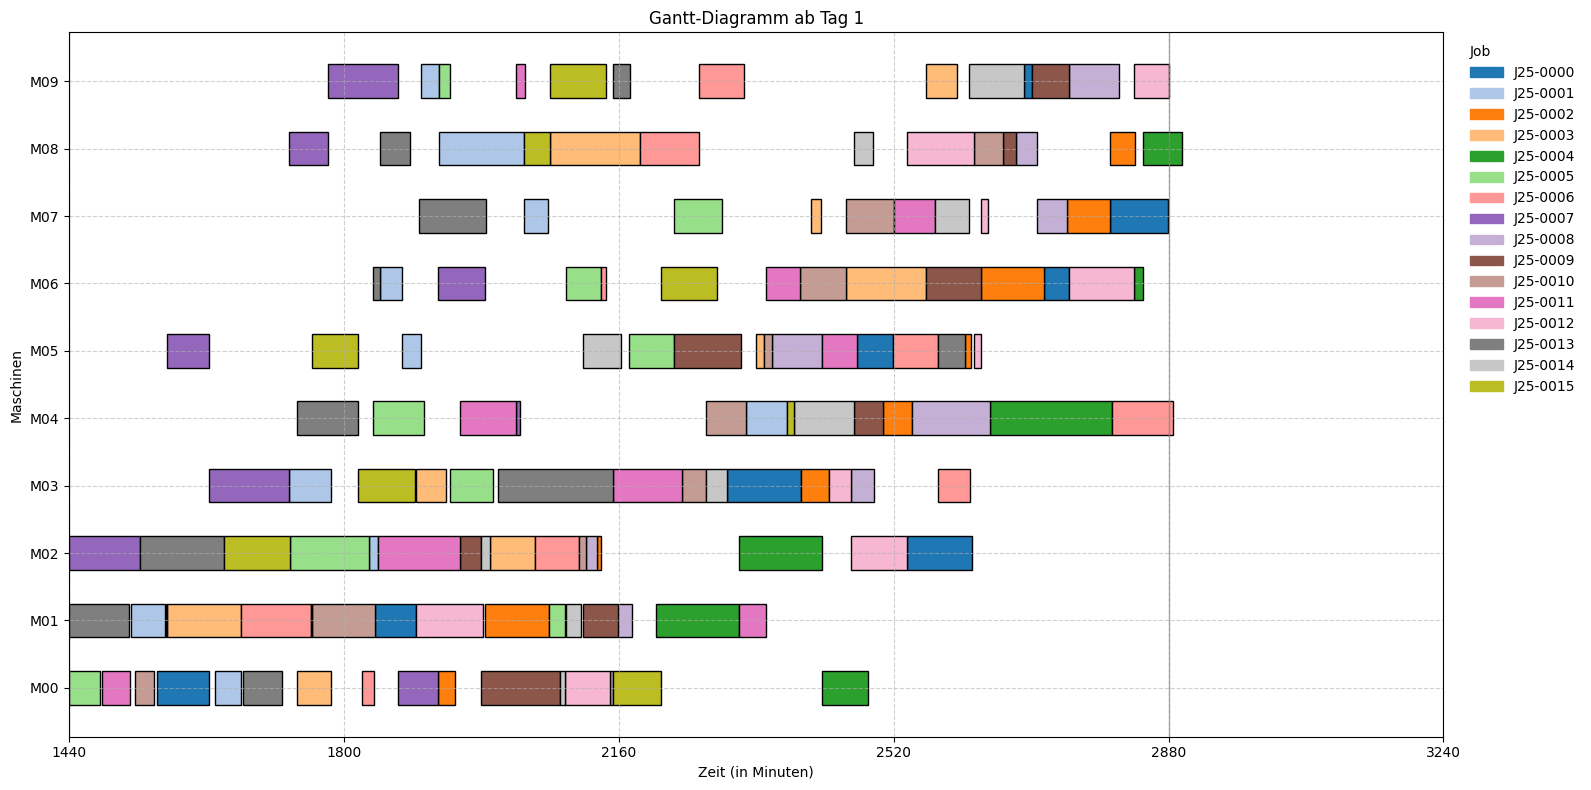

In [33]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

In [34]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 19
